# Modelo de Predicción de Stroke con Deep Neural Network

Este notebook implementa un modelo de predicción de stroke utilizando una red neuronal profunda (DNN) con las siguientes características:

- Imputación de valores faltantes con Random Forest
- Balanceo de clases con SMOTE
- Optimización automática de hiperparámetros (AutoHPO)
- Evaluación completa del modelo
- Guardado del modelo para uso futuro

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Para imputación con Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Para preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Para balanceo de clases
from imblearn.over_sampling import SMOTE

# Para redes neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Para optimización de hiperparámetros
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import Objective

# Para evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Configuración para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

## 1. Carga y Exploración de Datos

In [3]:
# Cargar el dataset
print("Cargando dataset...")
data_path = 'cleaned_dataset.csv'
data = pd.read_csv(data_path)

# Mostrar información del dataset
print("Información del dataset:")
print(f"Forma del dataset: {data.shape}")
print("Primeras 5 filas:")
data.head()

Cargando dataset...
Información del dataset:
Forma del dataset: (5516, 17)
Primeras 5 filas:


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,3.0,0,0,0,0,95.12,18.0,0,0,0,0,1,1,0,0,0
1,1,58.0,1,0,1,1,87.96,39.2,0,0,1,0,0,0,0,1,0
2,0,8.0,0,0,0,1,110.89,17.6,0,0,1,0,0,1,0,0,0
3,0,70.0,0,0,1,0,69.04,35.9,0,0,1,0,0,0,1,0,0
4,0,52.0,0,0,1,1,77.59,17.7,0,0,1,0,0,0,1,0,0


Distribución de la variable objetivo (stroke):
stroke
0    4733
1     783
Name: count, dtype: int64
Porcentaje de la clase minoritaria (stroke=1): 14.20%


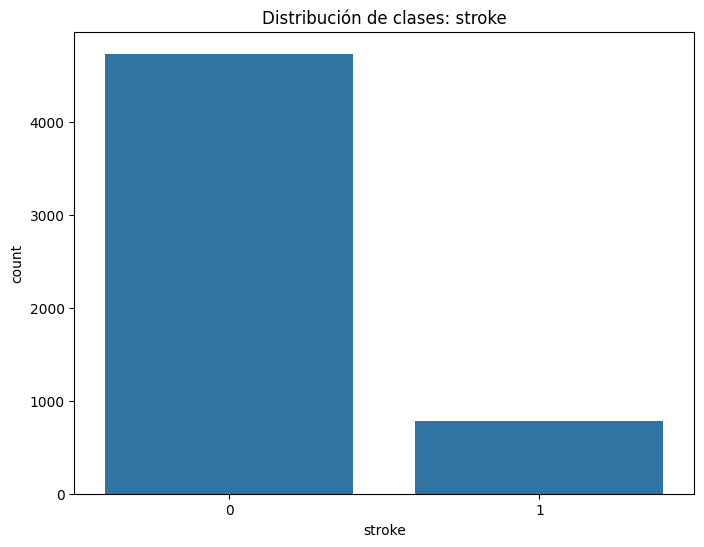

In [5]:
# Verificar distribución de la variable objetivo
print("Distribución de la variable objetivo (stroke):")
print(data['stroke'].value_counts())
print(f"Porcentaje de la clase minoritaria (stroke=1): {data['stroke'].mean() * 100:.2f}%")

# Visualizar la distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(x='stroke', data=data)
plt.title('Distribución de clases: stroke')
plt.show()

## 2. Preprocesamiento de Datos

In [6]:
# Separar características y variable objetivo
X = data.drop('stroke', axis=1)
y = data['stroke']

In [7]:
# Imputación de valores faltantes usando Random Forest
print("Imputando valores faltantes con Random Forest...")
rf_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42),
                             random_state=42, max_iter=10)
X_imputed = rf_imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Verificar que no haya valores nulos después de la imputación
print("Valores nulos después de la imputación:")
X.isnull().sum().sum()

Imputando valores faltantes con Random Forest...
Valores nulos después de la imputación:


0

In [8]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Aplicando SMOTE para balancear las clases...
Distribución de clases después de SMOTE:
Clase 0: 3786 muestras
Clase 1: 3786 muestras


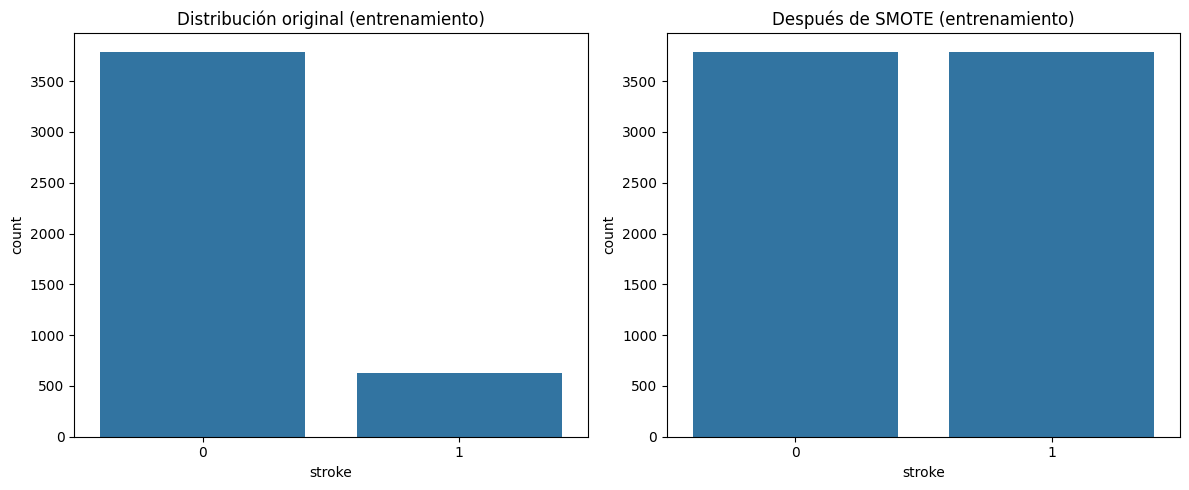

In [9]:
# Aplicar SMOTE para balancear las clases (solo en el conjunto de entrenamiento)
print("Aplicando SMOTE para balancear las clases...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Verificar la nueva distribución de clases después de SMOTE
print("Distribución de clases después de SMOTE:")
unique, counts = np.unique(y_train_smote, return_counts=True)
for value, count in zip(unique, counts):
    print(f"Clase {value}: {count} muestras")

# Visualizar la distribución de clases después de SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribución original (entrenamiento)')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote)
plt.title('Después de SMOTE (entrenamiento)')

plt.tight_layout()
plt.show()

## 3. Definición del Modelo y Optimización de Hiperparámetros

In [24]:
# Definir el modelo base para la búsqueda de hiperparámetros
def build_model(hp):
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_input', values=['relu', 'selu', 'elu']),
        kernel_regularizer=l2(hp.Float('l2_input', min_value=1e-5, max_value=1e-2, sampling='log')),
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_input', min_value=0.0, max_value=0.5, step=0.1)))
    
    # Capas ocultas
    for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=3)):
        model.add(Dense(
            units=hp.Int(f'units_hidden_{i}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'activation_hidden_{i}', values=['relu', 'selu', 'elu']),
            kernel_regularizer=l2(hp.Float(f'l2_hidden_{i}', min_value=1e-5, max_value=1e-2, sampling='log'))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_hidden_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
    )
    
    return model

In [25]:
# Configurar la búsqueda de hiperparámetros
print("Iniciando optimización automatizada de hiperparámetros (AutoHPO)...")
tuner = RandomSearch(
    build_model,
    objective=Objective('val_auc', direction='max'),
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='stroke_prediction_dnn'
)

# Callbacks para el entrenamiento
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Buscar los mejores hiperparámetros
tuner.search(
    X_train_smote, y_train_smote,
    epochs=50,  # Reducido para el notebook
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Iniciando optimización automatizada de hiperparámetros (AutoHPO)...
Reloading Tuner from keras_tuner_dir\stroke_prediction_dnn\tuner0.json


In [26]:
# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Mejores hiperparámetros encontrados:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Construir el modelo con los mejores hiperparámetros
best_model = tuner.hypermodel.build(best_hps)

Mejores hiperparámetros encontrados:
units_input: 160
activation_input: relu
l2_input: 0.0009084734581471714
dropout_input: 0.0
num_hidden_layers: 1
units_hidden_0: 48
activation_hidden_0: elu
l2_hidden_0: 0.0015387249733153636
dropout_hidden_0: 0.2
learning_rate: 0.00037880942111362035
units_hidden_1: 96
activation_hidden_1: selu
l2_hidden_1: 0.0005247660529339657
dropout_hidden_1: 0.4
units_hidden_2: 96
activation_hidden_2: relu
l2_hidden_2: 0.00016952572690285674
dropout_hidden_2: 0.30000000000000004


In [27]:
# Entrenar el modelo final con los mejores hiperparámetros
history = best_model.fit(
    X_train_smote, y_train_smote,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
190/190 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.7286 - auc: 0.8040 - recall_2: 0.7609 - precision_2: 0.6108 - val_loss: 0.5730 - val_accuracy: 0.8594 - val_auc: 0.0000e+00 - val_recall_2: 0.8594 - val_precision_2: 1.0000 - lr: 3.7881e-04
Epoch 2/100
190/190 [==============================] - 0s 2ms/step - loss: 0.6146 - accuracy: 0.7669 - auc: 0.8416 - recall_2: 0.7459 - precision_2: 0.6698 - val_loss: 0.5626 - val_accuracy: 0.8363 - val_auc: 0.0000e+00 - val_recall_2: 0.8363 - val_precision_2: 1.0000 - lr: 3.7881e-04
Epoch 3/100
190/190 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.7755 - auc: 0.8486 - recall_2: 0.7402 - precision_2: 0.6858 - val_loss: 0.5907 - val_accuracy: 0.8436 - val_auc: 0.0000e+00 - val_recall_2: 0.8436 - val_precision_2: 1.0000 - lr: 3.7881e-04
Epoch 4/100
190/190 [==============================] - 0s 2ms/step - loss: 0.5735 - accuracy: 0.7845 - auc: 0.8560 - recall_2: 0.7371 - precis

## 4. Evaluación del Modelo

In [28]:
# Evaluar el modelo en el conjunto de prueba
print("Evaluando el modelo en el conjunto de prueba...")
test_results = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"AUC: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")
print(f"Precision: {test_results[4]:.4f}")

Evaluando el modelo en el conjunto de prueba...
Loss: 0.4956
Accuracy: 0.7908
AUC: 0.8072
Recall: 0.5924
Precision: 0.3577


In [29]:
# Predecir en el conjunto de prueba
y_pred_proba = best_model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

35/35 [==============================] - 0s 574us/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       947
           1       0.36      0.59      0.45       157

    accuracy                           0.79      1104
   macro avg       0.64      0.71      0.66      1104
weighted avg       0.84      0.79      0.81      1104



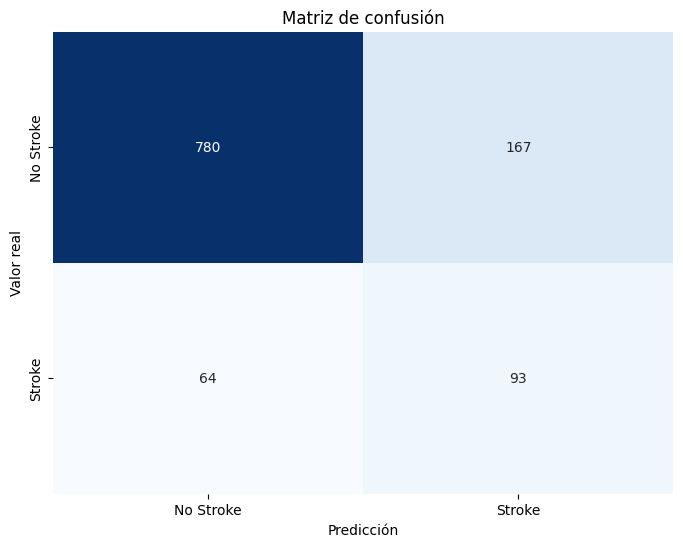

In [30]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['No Stroke', 'Stroke'],
           yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.show()

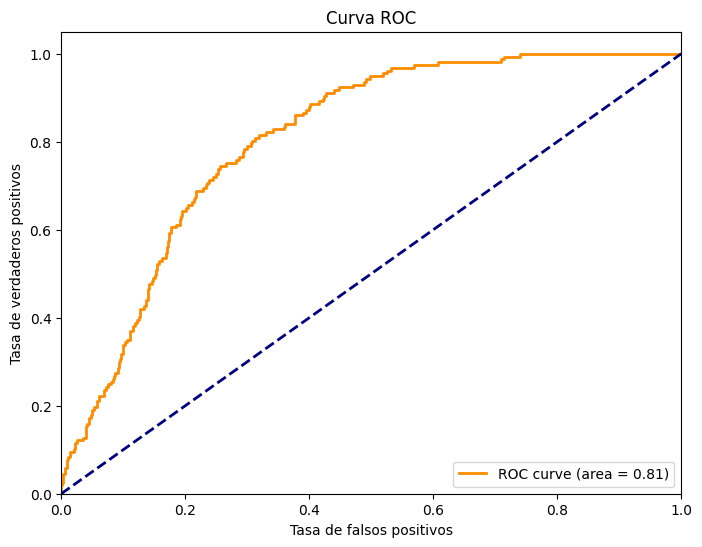

In [31]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

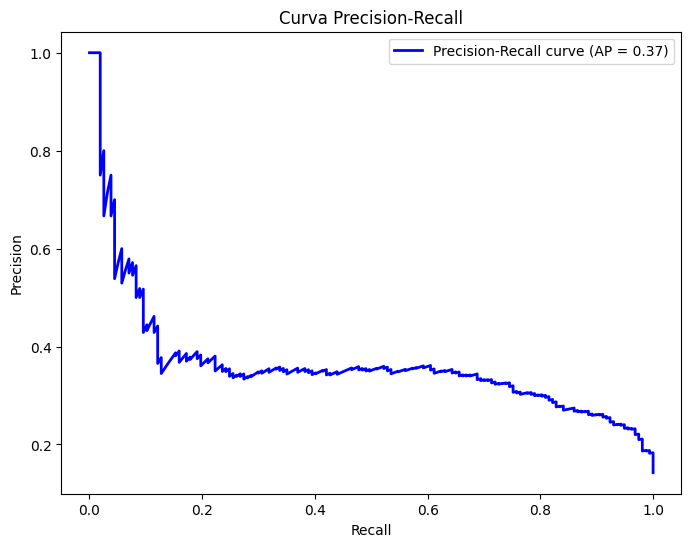

In [32]:
# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc='upper right')
plt.show()

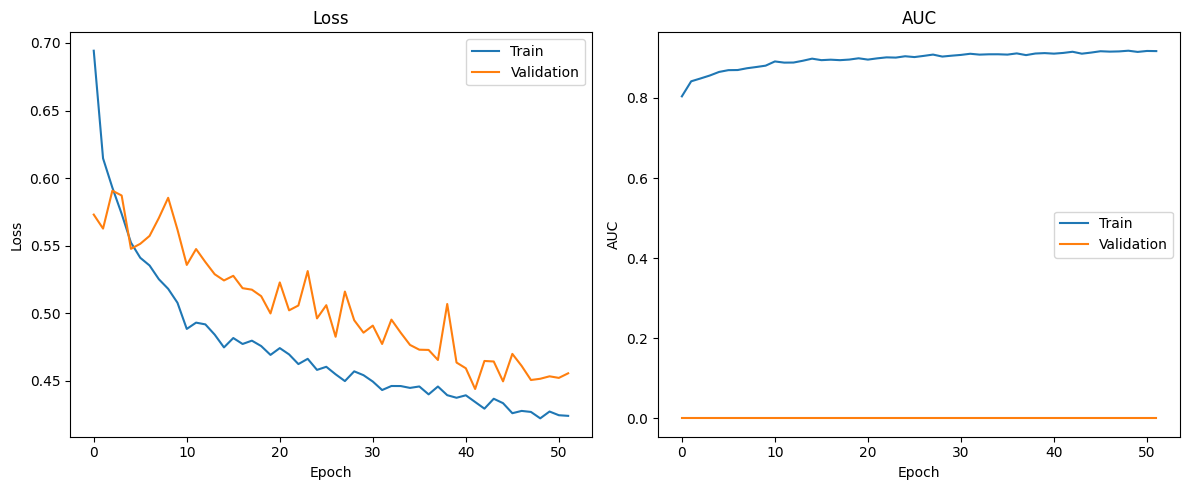

In [33]:
# Visualizar la historia del entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Validation')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Guardar el Modelo

In [34]:
# Guardar el modelo
model_path = 'dnn_stroke_prediction_model.h5'
best_model.save(model_path)
print(f"Modelo guardado como: {model_path}")

# Guardar el scaler para futuras predicciones
scaler_path = 'dnn_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler guardado como: {scaler_path}")

# Guardar el imputador para futuras predicciones
imputer_path = 'rf_imputer.pkl'
with open(imputer_path, 'wb') as f:
    pickle.dump(rf_imputer, f)
print(f"Imputador guardado como: {imputer_path}")

e:\My documents\Cursos\Bootcamp IA\Proyecto-IX-DS2\tf_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo guardado como: dnn_stroke_prediction_model.h5
Scaler guardado como: dnn_scaler.pkl
Imputador guardado como: rf_imputer.pkl


## 6. Función para Realizar Predicciones

In [35]:
# Función para realizar predicciones con el modelo entrenado
def predict_stroke(data, threshold=0.5):
    """
    Realiza predicciones utilizando el modelo entrenado.
    
    Args:
        data: DataFrame con las características del paciente
        threshold: Umbral de decisión para la clasificación (default: 0.5)
        
    Returns:
        prediction: Predicción binaria (0: No stroke, 1: Stroke)
        probability: Probabilidad de stroke
    """
    # Imputar valores faltantes
    data_imputed = rf_imputer.transform(data)
    
    # Escalar características
    data_scaled = scaler.transform(data_imputed)
    
    # Realizar predicción
    probability = best_model.predict(data_scaled)[0][0]
    prediction = 1 if probability > threshold else 0
    
    return prediction, probability

In [36]:
# Ejemplo de uso de la función de predicción
print("Ejemplo de predicción:")
sample = X_test.iloc[0:1]
prediction, probability = predict_stroke(sample)
print(f"Características del paciente:{sample}")
print(f"Predicción: {'Stroke' if prediction == 1 else 'No Stroke'}")
print(f"Probabilidad de stroke: {probability:.4f}")
print(f"Valor real: {'Stroke' if y_test.iloc[0] == 1 else 'No Stroke'}")

print("Proceso completado.")

Ejemplo de predicción:
1/1 [==============================] - 0s 49ms/step
Características del paciente:      gender   age  hypertension  heart_disease  ever_married  Residence_type  \
2204     1.0  10.0           0.0            0.0           0.0             1.0   

      avg_glucose_level   bmi  work_type_Govt_job  work_type_Private  \
2204              76.92  15.8                 0.0                0.0   

      work_type_Self-employed  work_type_children  smoking_status_Unknown  \
2204                      0.0                 1.0                     1.0   

      smoking_status_formerly smoked  smoking_status_never smoked  \
2204                             0.0                          0.0   

      smoking_status_smokes  
2204                    0.0  
Predicción: No Stroke
Probabilidad de stroke: 0.0022
Valor real: No Stroke
Proceso completado.


e:\My documents\Cursos\Bootcamp IA\Proyecto-IX-DS2\tf_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
